# Biodiversity data - Codecademy Portfolio Project

We will be exploring two CSV files:

* species_info.csv - contains data about different species and their conservation status
* observations.csv - holds recorded sightings of different species at several national parks for the past 7 days.

species_info.csv:

* category - class of animal
* scientific_name - the scientific name of each species
* common_name - the common names of each species
* conservation_status - each species’ current conservation status

observations.csv:

* scientific_name - the scientific name of each species
* park_name - Park where species were found
* observations - the number of times each species was observed at park

### Import Python Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from IPython.display import display
from tabulate import tabulate
from scipy.stats import chi2_contingency

ModuleNotFoundError: No module named 'tabulate'

## Data file species_info.csv

### Loading

In [ ]:
species_info = pd.read_csv('species_info.csv')
# print(tabulate(species_info.head(), headers='keys', tablefmt='pretty'))
display(species_info.head())

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


### Columns data types and counts

In [ ]:
species_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5824 entries, 0 to 5823
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   category             5824 non-null   object
 1   scientific_name      5824 non-null   object
 2   common_names         5824 non-null   object
 3   conservation_status  191 non-null    object
dtypes: object(4)
memory usage: 182.1+ KB


In [ ]:
maxRows = species_info['category'].count()
print('Missing Data:')
percent = (1 - species_info.count() / maxRows) * 100
print(percent.apply(lambda x: '{:.2f}%'.format(x)))

Missing Data:
category                0.00%
scientific_name         0.00%
common_names            0.00%
conservation_status    96.72%
dtype: object


### Observations

* The conservation_status column seem to contains mosty NaN values. Only about 3% non-missing values.
* The other three columns do not seem to miss data.

### Checking the categories of the columns

In [ ]:
print(species_info.category.value_counts())
print()
print(species_info.scientific_name.value_counts())
print()
print(species_info.common_names.value_counts())
print()
print(species_info.conservation_status.value_counts())

category
Vascular Plant       4470
Bird                  521
Nonvascular Plant     333
Mammal                214
Fish                  127
Amphibian              80
Reptile                79
Name: count, dtype: int64

scientific_name
Procyon lotor             3
Myotis lucifugus          3
Canis lupus               3
Castor canadensis         3
Hypochaeris radicata      3
                         ..
Solanum parishii          1
Solanum xanti             1
Parthenocissus vitacea    1
Vitis californica         1
Saxifraga oregana         1
Name: count, Length: 5541, dtype: int64

common_names
Brachythecium Moss                                                            7
Dicranum Moss                                                                 7
Bryum Moss                                                                    6
Panic Grass                                                                   6
Sphagnum                                                                      6
    

### Observations

* The columns **category** and **conservation_status** contains substantial categories
* About 80% of the "animals" in the dataset are **plants**.
* The columns **scientific_name** and **common_names** contain strings
* The columns **scientific_name** and **common_names** are supposedly unique values. Yet we can see that both contains duplicates. We need to investigate and eliminate this.
* The columns **scientific_name**
* In the column **conservation_status**
  * Only about 3% of the data are not missing
  * The values 'Species of Concern', 'Endangered' and 'Threatened' seem to mean the same.  
The fourth value 'In Recovery' seems also to mean 'of concern' but perhaps more specific.
* l intend to add a new column **is_endangered** which is true iff conservation_status is not null

### Missing conservation_status data per species category

Let's see if there is a visible relationship between species category and missing data on conservation status.

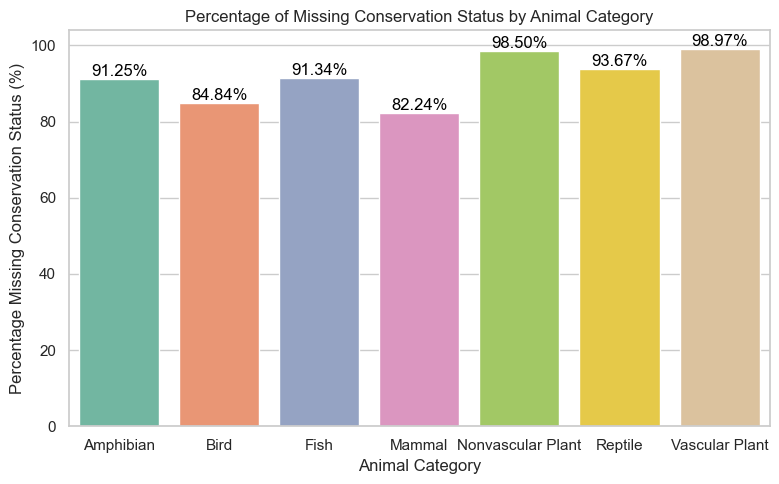

In [ ]:
# Group the DataFrame and compute the percentages
agg_df = species_info.groupby('category').agg(
    total_instances=('conservation_status', 'size'),
    missing_count=('conservation_status', lambda x: x.isnull().sum())
).reset_index()

# Calculate percentage and format it for printing
agg_df['missing_percentage'] = (agg_df['missing_count'] / agg_df['total_instances']) * 100
agg_df['formatted_percentage'] = agg_df['missing_percentage'].map("{:.2f}%".format)

# print("Percentage of missing 'conservation_status' values by animal category:")
# print(agg_df[['category', 'formatted_percentage']])

# Plot using seaborn to visualize percentages
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 5))
barplot = sns.barplot(
    data=agg_df,
    x='category',
    y='missing_percentage',
    palette='Set2',
    hue='category',
    legend=False
)

barplot.set_title('Percentage of Missing Conservation Status by Animal Category')
barplot.set_xlabel('Animal Category')
barplot.set_ylabel('Percentage Missing Conservation Status (%)')

# Add data labels showing the percentages above each bar
for index, row in agg_df.iterrows():
    barplot.text(
        index, row['missing_percentage'],
        f"{row['missing_percentage']:.2f}%",
        color='black', ha="center", va="bottom"
    )

plt.tight_layout()
plt.show()


### Observations

The missing values in conservation status seem nearly evenly distributed amoung the species categories.  
There is no visible correlations between missing values and species category.

 ### Adding a column: is_endangered

In [ ]:
species_info['is_endangered'] = ~species_info['conservation_status'].isnull()
print(species_info['is_endangered'].value_counts())


is_endangered
False    5633
True      191
Name: count, dtype: int64


### Checking scientific_name duplicates

In [ ]:
has_duplicate_scientific_names = species_info.duplicated(subset=['scientific_name'])
print('Count duplicated scientific names:')
print(has_duplicate_scientific_names.sum())

duplicate_scientific_names = species_info.scientific_name[species_info.scientific_name.duplicated()]

# Display the first 5 duplicate scientific names
print("\nDisplay some duplicate scientific names")
for name in duplicate_scientific_names[:5]:
    display(species_info[species_info['scientific_name'] == name])
display(species_info[species_info['scientific_name'] == 'Oncorhynchus mykiss'])

Count duplicated scientific names:
283

Display some duplicate scientific names


,category,scientific_name,common_names,conservation_status,is_endangered
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN,False
3017,Mammal,Cervus elaphus,Rocky Mountain Elk,NaN,False


,category,scientific_name,common_names,conservation_status,is_endangered
5,Mammal,Odocoileus virginianus,White-Tailed Deer,NaN,False
3019,Mammal,Odocoileus virginianus,"White-Tailed Deer, White-Tailed Deer",NaN,False


,category,scientific_name,common_names,conservation_status,is_endangered
8,Mammal,Canis lupus,Gray Wolf,Endangered,True
3020,Mammal,Canis lupus,"Gray Wolf, Wolf",In Recovery,True
4448,Mammal,Canis lupus,"Gray Wolf, Wolf",Endangered,True


,category,scientific_name,common_names,conservation_status,is_endangered
16,Mammal,Puma concolor,Panther (Mountain Lion),NaN,False
3022,Mammal,Puma concolor,"Cougar, Mountain Lion, Puma",NaN,False
4451,Mammal,Puma concolor,Mountain Lion,NaN,False


,category,scientific_name,common_names,conservation_status,is_endangered
20,Mammal,Lutra canadensis,Northern River Otter,NaN,False
3025,Mammal,Lutra canadensis,River Otter,NaN,False


,category,scientific_name,common_names,conservation_status,is_endangered
560,Fish,Oncorhynchus mykiss,Rainbow Trout,NaN,False
3283,Fish,Oncorhynchus mykiss,Rainbow Trout,Threatened,True


### Observations

* We have rows with duplicate scientific_name that we need to eliminate
* We need to eliminate the duplicates not by simple deletion though. We need to unite all the common_names that have been assigned to a given scientific_name in all its duplicates.

### Fixing scientific_name duplicates

* Currently there are scientific_name values for which there is more than one row. After this stage there will be only one row.
* We will collect all the common_names that have been associated with a scientific_name in all the original rows.
* If in some rows is_endangered is true and in some false, we will assign the value true (= is endangered)

In [ ]:
species_info_cleaned = species_info.groupby(['scientific_name', 'category']).agg(
    common_names=('common_names', lambda x: ', '.join(sorted(set(', '.join(x).split(', '))))) ,
    is_endangered=('is_endangered', 'max')  # If any row is True, keep it as True
).reset_index()

# Check results
print("Cleaned species_info dataset:")
print(tabulate(species_info_cleaned.head(), headers='keys', tablefmt='pretty'))
print()
print(species_info_cleaned.info())
print()
print(species_info_cleaned.category.value_counts())
print()
print(species_info_cleaned.scientific_name.value_counts())
print()
print(species_info_cleaned.common_names.value_counts())
print()
print(species_info_cleaned.is_endangered .value_counts())

# Assign the cleaned DataFrame to the original variable name
species_info = species_info_cleaned

Cleaned species_info dataset:
+---+----------------------+-------------------+-----------------------------------------------------------------------------+---------------+
|   |   scientific_name    |     category      |                                common_names                                 | is_endangered |
+---+----------------------+-------------------+-----------------------------------------------------------------------------+---------------+
| 0 |    Abies bifolia     |  Vascular Plant   |                          Rocky Mountain Alpine Fir                          |     False     |
| 1 |    Abies concolor    |  Vascular Plant   | Balsam Fir, Colorado Fir, Concolor Fir, Silver Fir, White Balsam, White Fir |     False     |
| 2 |    Abies fraseri     |  Vascular Plant   |                                 Fraser Fir                                  |     True      |
| 3 | Abietinella abietina | Nonvascular Plant |                              Abietinella Moss                  

### Observations

* From 5824 original rows in species_info we are now down to 5541 rows
* But we still have duplicates in the common_names columns. Next we will look into this.

### Checking common_names duplicates

In [ ]:
has_duplicates = species_info.duplicated(subset=['common_names'])
print('Count duplicated common_names:')
print(has_duplicates.sum())

duplicates = species_info.common_names[species_info.common_names.duplicated()]

# Display the first 5 duplicates
print("\nDisplay some duplicate common_names")
for name in duplicates[:5]:
    display(species_info[species_info['common_names'] == name])

Count duplicated common_names:
305

Display some duplicate common_names


,scientific_name,category,common_names,is_endangered
45,Aconitum columbianum,Vascular Plant,Columbian Monkshood,False
46,Aconitum columbianum ssp. columbianum,Vascular Plant,Columbian Monkshood,False


,scientific_name,category,common_names,is_endangered
53,Actitis macularia,Bird,Spotted Sandpiper,False
54,Actitis macularius,Bird,Spotted Sandpiper,False


,scientific_name,category,common_names,is_endangered
82,Ageratina altissima,Vascular Plant,White Snakeroot,False
83,Ageratina altissima var. altissima,Vascular Plant,White Snakeroot,False
84,Ageratina altissima var. roanensis,Vascular Plant,White Snakeroot,False


,scientific_name,category,common_names,is_endangered
82,Ageratina altissima,Vascular Plant,White Snakeroot,False
83,Ageratina altissima var. altissima,Vascular Plant,White Snakeroot,False
84,Ageratina altissima var. roanensis,Vascular Plant,White Snakeroot,False


,scientific_name,category,common_names,is_endangered
91,Agoseris glauca var. glauca,Vascular Plant,Pale Agoseris,False
93,Agoseris glauca var. monticola,Vascular Plant,Pale Agoseris,False


### Observations

* There are cases of similar scientific names which have the same common names. This does not currently seems to be a problem that requires cleaning or modification.
* Possibly for some purposes the rows for two scientific names like "Actitis macularia" and "Actitis macularius" need to be united. But I don't see a need for this right now.
* We are not investigating particular species here but categories of species. Does the category remains the same when the scientific name is a bit different? Probably. But even if there are such cases, what could I do about them? I would have to investigate them one by one. This is not reasonable for this exercise.
* Besides, if I purge scientific names I will have to modify the other dataset as well. Which is a complication that I prefer to avoid if possible.

### Distribution by Species Category

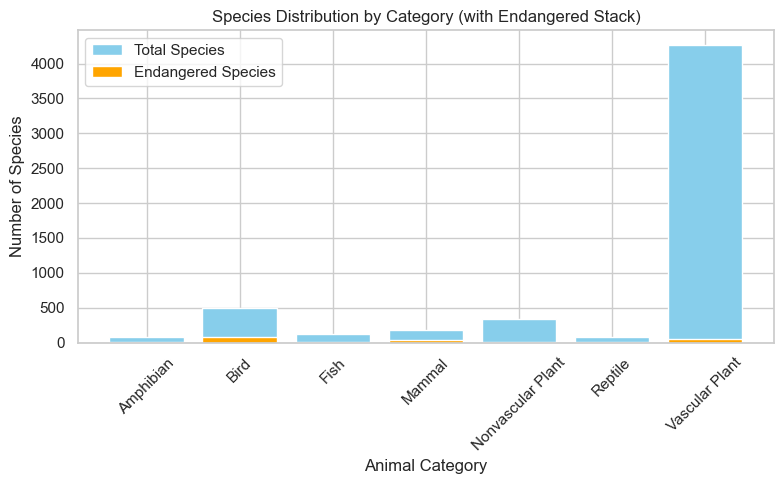

In [ ]:
# Count the total number of species and endangered species per category
category_counts = species_info.groupby('category').agg(
    total_species=('is_endangered', 'size'),
    endangered_species=('is_endangered', 'sum')
).reset_index()

# Plotting the stacked bar chart
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 5))

# Plot total species as base bars
plt.bar(
    category_counts['category'], 
    category_counts['total_species'], 
    color='skyblue', 
    label='Total Species'
)

# Add endangered species as stacked bars
plt.bar(
    category_counts['category'], 
    category_counts['endangered_species'], 
    color='orange', 
    label='Endangered Species'
)

# Add labels and titles
plt.title('Species Distribution by Category (with Endangered Stack)')
plt.xlabel('Animal Category')
plt.ylabel('Number of Species')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


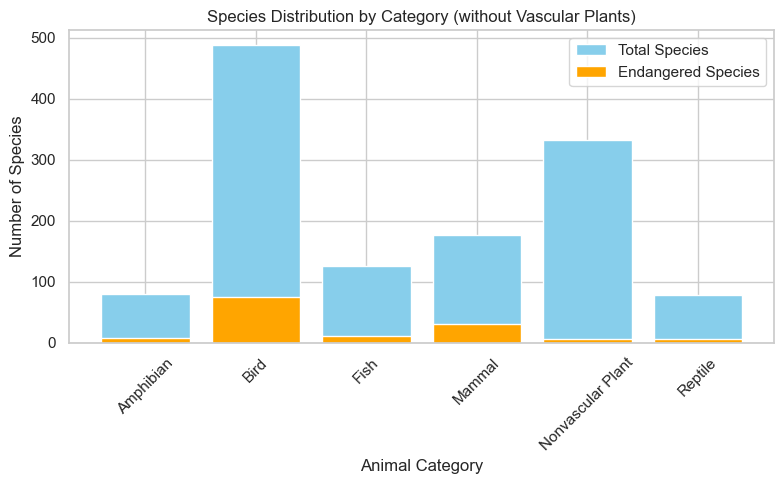

In [ ]:
# Display only categories with less than 1000 species
category_counts = category_counts[category_counts['total_species'] < 1000]

# Plotting the bar chart with updated practices
plt.figure(figsize=(8, 5))

# Plot total species as base bars
plt.bar(
    category_counts['category'], 
    category_counts['total_species'], 
    color='skyblue', 
    label='Total Species'
)

# Add endangered species as stacked bars
plt.bar(
    category_counts['category'], 
    category_counts['endangered_species'], 
    color='orange', 
    label='Endangered Species'
)

# Add labels and titles
plt.title('Species Distribution by Category (without Vascular Plants)')
plt.xlabel('Animal Category')
plt.ylabel('Number of Species')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### Observations

* The Vascular Plant category is by far the most populated category in the dataset. In has about 10 times more species than the next category in size, which is Birds.
* Categories which have significant percentages of endangered species are: Bird, Mammal, Fish.

### Endangered species per species category

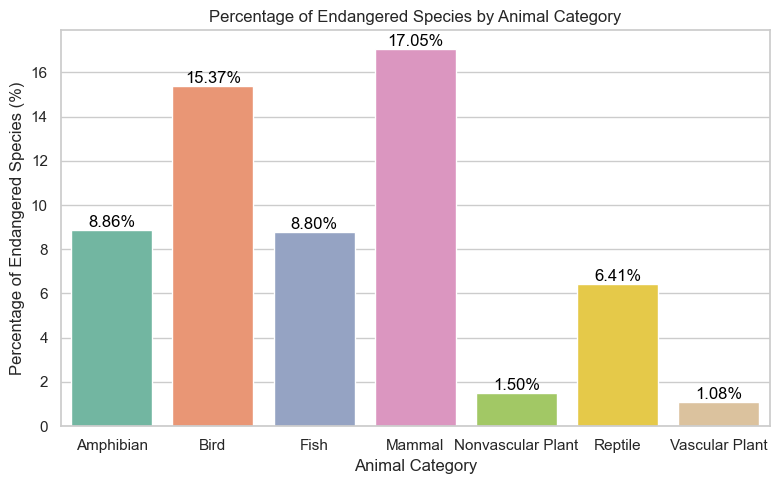

In [ ]:
# Group the DataFrame and calculate the percentage of endangered species
agg_df = species_info.groupby('category').agg(
    total_instances=('is_endangered', 'size'),
    endangered_count=('is_endangered', 'sum')
).reset_index()

# Calculate percentage of endangered species
agg_df['endangered_percentage'] = (agg_df['endangered_count'] / agg_df['total_instances']) * 100

# print("Percentage of endangered species by animal category:")
# agg_df['formatted_percentage'] = agg_df['endangered_percentage'].map("{:.2f}%".format)
# print(agg_df[['category', 'formatted_percentage']])

# Plot using seaborn
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 5))
barplot = sns.barplot(
    data=agg_df,
    x='category',
    y='endangered_percentage',
    palette='Set2',
    hue='category',
    legend=False
)

barplot.set_title('Percentage of Endangered Species by Animal Category')
barplot.set_xlabel('Animal Category')
barplot.set_ylabel('Percentage of Endangered Species (%)')

# Add percentage labels above bars
for index, row in agg_df.iterrows():
    barplot.text(
        index, row['endangered_percentage'],
        f"{row['endangered_percentage']:.2f}%",
        color='black', ha="center", va="bottom"
    )

plt.tight_layout()
plt.show()

### Observations

We can see that most species that are indicated as endangered in the dataset are either mammals or birds.  
Relatively few of the plants species are considered endangered.

## Data file observations.csv

### Loading

In [ ]:
observations = pd.read_csv('observations.csv')
display(observations.head())

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


### Columns data types and counts

In [ ]:
observations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23296 entries, 0 to 23295
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   scientific_name  23296 non-null  object
 1   park_name        23296 non-null  object
 2   observations     23296 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 546.1+ KB


### Observations

There are no missing data in the observations dataset.

### Park names

In [ ]:
observations.park_name.value_counts()

park_name
Great Smoky Mountains National Park    5824
Yosemite National Park                 5824
Bryce National Park                    5824
Yellowstone National Park              5824
Name: count, dtype: int64

### Observations

* The observations dataset contain data on observations of animals and plants in four parks.  
* Judging by the number of rows (4 * 5284) it seems that for each of the four parks we have a row for every species in the species_info dataset.
* But the 5824 rows in species_info contained duplicates. We need to check for duplicates here too then.

### Checking scientific_name duplicates in the Observations dataset

In [ ]:
park_names = observations.park_name.unique()

for park_name in park_names:
    print(f"Park Name: {park_name}")
    partial_observations = observations[observations['park_name'] == park_name]
    has_duplicate_scientific_names = partial_observations.duplicated(subset=['scientific_name'])
    print('Count duplicated scientific names for park {}:'.format(park_name))
    print(has_duplicate_scientific_names.sum())

    duplicate_scientific_names = partial_observations.scientific_name[partial_observations.scientific_name.duplicated()]

    # Display the first 2 duplicate scientific names
    print("\nDisplay some duplicate scientific names")
    for name in duplicate_scientific_names[:2]:
        display(partial_observations[partial_observations['scientific_name'] == name])

Park Name: Great Smoky Mountains National Park
Count duplicated scientific names for park Great Smoky Mountains National Park:
283

Display some duplicate scientific names


,scientific_name,park_name,observations
675,Rana catesbeiana,Great Smoky Mountains National Park,88
1267,Rana catesbeiana,Great Smoky Mountains National Park,81


,scientific_name,park_name,observations
133,Hypochaeris radicata,Great Smoky Mountains National Park,57
1519,Hypochaeris radicata,Great Smoky Mountains National Park,73
22139,Hypochaeris radicata,Great Smoky Mountains National Park,65


Park Name: Yosemite National Park
Count duplicated scientific names for park Yosemite National Park:
283

Display some duplicate scientific names


,scientific_name,park_name,observations
111,Agrostis mertensii,Yosemite National Park,135
490,Agrostis mertensii,Yosemite National Park,128


,scientific_name,park_name,observations
890,Charina bottae,Yosemite National Park,161
1318,Charina bottae,Yosemite National Park,135


Park Name: Bryce National Park
Count duplicated scientific names for park Bryce National Park:
283

Display some duplicate scientific names


,scientific_name,park_name,observations
714,Dianthus barbatus,Bryce National Park,85
1213,Dianthus barbatus,Bryce National Park,110


,scientific_name,park_name,observations
872,Riparia riparia,Bryce National Park,88
1259,Riparia riparia,Bryce National Park,91


Park Name: Yellowstone National Park
Count duplicated scientific names for park Yellowstone National Park:
283

Display some duplicate scientific names


,scientific_name,park_name,observations
449,Agrostis gigantea,Yellowstone National Park,253
483,Agrostis gigantea,Yellowstone National Park,235


,scientific_name,park_name,observations
308,Rumex crispus,Yellowstone National Park,256
945,Rumex crispus,Yellowstone National Park,255


### Observations

* We have in the observations dataset a duplication, similar to what we saw in the species_info dataset. We have multiple row with the same scientific_name!
* Do rows with the same park_name and scientific_name count mutually exclusive observations? This is what I will assume, since I do not have any information on this.

### Fixing scientific_name duplicates in the Observations dataset

* As stated, I will assume that rows with the same park_name and scientific_name count mutually exclusive observations.
* Accordingly, I will replace such a group of dupicate rows with one row, in which the "observations" count is the sum of the counts of the original duplicate rows.

In [ ]:
observations_cleaned = observations.groupby(['scientific_name', 'park_name'], as_index=False)['observations'].sum()

print("Cleaned observations dataset:")
print(observations_cleaned.info())
print()
print(observations_cleaned.park_name.value_counts())
print()
# Compare the cleaned observations with the original observations
print("Compare cleaned observations with original observations:")
for park_name in park_names:
    print(f"Park Name: {park_name}")
    partial_observations = observations[observations['park_name'] == park_name]
    partial_observations_cleaned = observations_cleaned[observations_cleaned['park_name'] == park_name]
    has_duplicate_scientific_names = partial_observations.duplicated(subset=['scientific_name'])
    print('Count duplicated scientific names for park {}:'.format(park_name))
    print(has_duplicate_scientific_names.sum())

    duplicate_scientific_names = partial_observations.scientific_name[partial_observations.scientific_name.duplicated()]

    # Display the first 2 duplicate scientific names
    print("\nDisplay some duplicate scientific names")
    for name in duplicate_scientific_names[:2]:
        display(partial_observations[partial_observations['scientific_name'] == name])
        display(partial_observations_cleaned[partial_observations_cleaned['scientific_name'] == name])

observations = observations_cleaned

Cleaned observations dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22164 entries, 0 to 22163
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   scientific_name  22164 non-null  object
 1   park_name        22164 non-null  object
 2   observations     22164 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 519.6+ KB
None

park_name
Bryce National Park                    5541
Great Smoky Mountains National Park    5541
Yellowstone National Park              5541
Yosemite National Park                 5541
Name: count, dtype: int64

Compare cleaned observations with original observations:
Park Name: Great Smoky Mountains National Park
Count duplicated scientific names for park Great Smoky Mountains National Park:
283

Display some duplicate scientific names


,scientific_name,park_name,observations
675,Rana catesbeiana,Great Smoky Mountains National Park,88
1267,Rana catesbeiana,Great Smoky Mountains National Park,81


,scientific_name,park_name,observations
16965,Rana catesbeiana,Great Smoky Mountains National Park,169


,scientific_name,park_name,observations
133,Hypochaeris radicata,Great Smoky Mountains National Park,57
1519,Hypochaeris radicata,Great Smoky Mountains National Park,73
22139,Hypochaeris radicata,Great Smoky Mountains National Park,65


,scientific_name,park_name,observations
10221,Hypochaeris radicata,Great Smoky Mountains National Park,195


Park Name: Yosemite National Park
Count duplicated scientific names for park Yosemite National Park:
283

Display some duplicate scientific names


,scientific_name,park_name,observations
111,Agrostis mertensii,Yosemite National Park,135
490,Agrostis mertensii,Yosemite National Park,128


,scientific_name,park_name,observations
447,Agrostis mertensii,Yosemite National Park,263


,scientific_name,park_name,observations
890,Charina bottae,Yosemite National Park,161
1318,Charina bottae,Yosemite National Park,135


,scientific_name,park_name,observations
4799,Charina bottae,Yosemite National Park,296


Park Name: Bryce National Park
Count duplicated scientific names for park Bryce National Park:
283

Display some duplicate scientific names


,scientific_name,park_name,observations
714,Dianthus barbatus,Bryce National Park,85
1213,Dianthus barbatus,Bryce National Park,110


,scientific_name,park_name,observations
6564,Dianthus barbatus,Bryce National Park,195


,scientific_name,park_name,observations
872,Riparia riparia,Bryce National Park,88
1259,Riparia riparia,Bryce National Park,91


,scientific_name,park_name,observations
17496,Riparia riparia,Bryce National Park,179


Park Name: Yellowstone National Park
Count duplicated scientific names for park Yellowstone National Park:
283

Display some duplicate scientific names


,scientific_name,park_name,observations
449,Agrostis gigantea,Yellowstone National Park,253
483,Agrostis gigantea,Yellowstone National Park,235


,scientific_name,park_name,observations
430,Agrostis gigantea,Yellowstone National Park,488


,scientific_name,park_name,observations
308,Rumex crispus,Yellowstone National Park,256
945,Rumex crispus,Yellowstone National Park,255


,scientific_name,park_name,observations
17798,Rumex crispus,Yellowstone National Park,511


### Observations

* The duplicate rows in the observations dataset seem to have been purged, as specified.

## The two datasets together

### Merging the two datasets

In [ ]:
# Merge the dataframes on 'scientific_name'
merged_df = pd.merge(observations, species_info, on='scientific_name')

print("Merged DataFrame:")
display(merged_df.head())
print(merged_df.info())
print()
print(merged_df.park_name.value_counts())

# Aggregate data: calculate total and endangered observations for each park and category
agg_df = merged_df.groupby(['park_name', 'category']).agg(
    total_observations=('observations', 'sum'),
    endangered_observations=('is_endangered', lambda x: (x * merged_df.loc[x.index, 'observations']).sum())
).reset_index()

print("Aggregated observations data:")
display(agg_df)

Merged DataFrame:


,scientific_name,park_name,observations,category,common_names,is_endangered
0,Abies bifolia,Bryce National Park,109,Vascular Plant,Rocky Mountain Alpine Fir,False
1,Abies bifolia,Great Smoky Mountains National Park,72,Vascular Plant,Rocky Mountain Alpine Fir,False
2,Abies bifolia,Yellowstone National Park,215,Vascular Plant,Rocky Mountain Alpine Fir,False
3,Abies bifolia,Yosemite National Park,136,Vascular Plant,Rocky Mountain Alpine Fir,False
4,Abies concolor,Bryce National Park,83,Vascular Plant,"Balsam Fir, Colorado Fir, Concolor Fir, Silver...",False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22164 entries, 0 to 22163
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   scientific_name  22164 non-null  object
 1   park_name        22164 non-null  object
 2   observations     22164 non-null  int64 
 3   category         22164 non-null  object
 4   common_names     22164 non-null  object
 5   is_endangered    22164 non-null  bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 887.6+ KB
None

park_name
Bryce National Park                    5541
Great Smoky Mountains National Park    5541
Yellowstone National Park              5541
Yosemite National Park                 5541
Name: count, dtype: int64
Aggregated observations data:


,park_name,category,total_observations,endangered_observations
0,Bryce National Park,Amphibian,7380,498
1,Bryce National Park,Bird,51647,6926
2,Bryce National Park,Fish,12423,731
3,Bryce National Park,Mammal,20550,3037
4,Bryce National Park,Nonvascular Plant,32992,486
5,Bryce National Park,Reptile,7950,387
6,Bryce National Park,Vascular Plant,443083,4198
7,Great Smoky Mountains National Park,Amphibian,5707,333
8,Great Smoky Mountains National Park,Bird,37728,4741
9,Great Smoky Mountains National Park,Fish,9206,547


### Observations by Category for each Park

Since there are much more observations in the "Vascular Plant" category, I will visuaize that category in a separate graph.

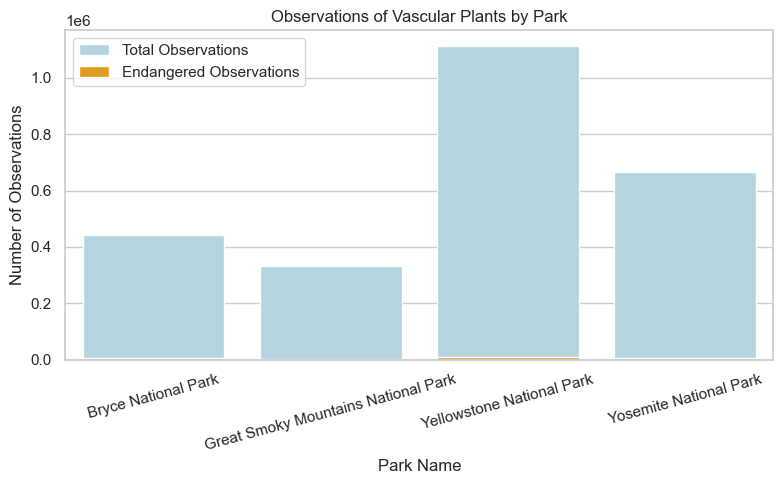

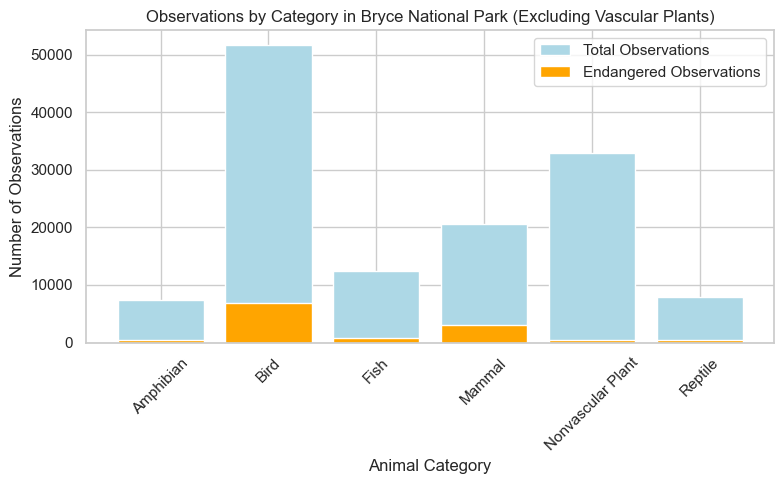

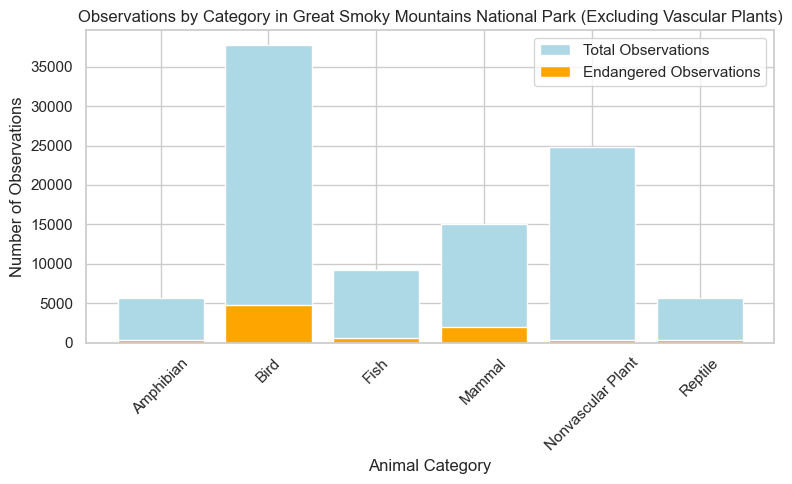

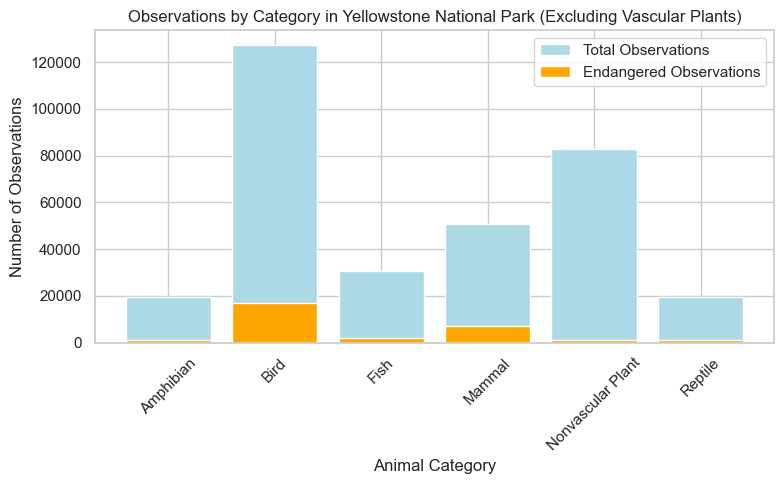

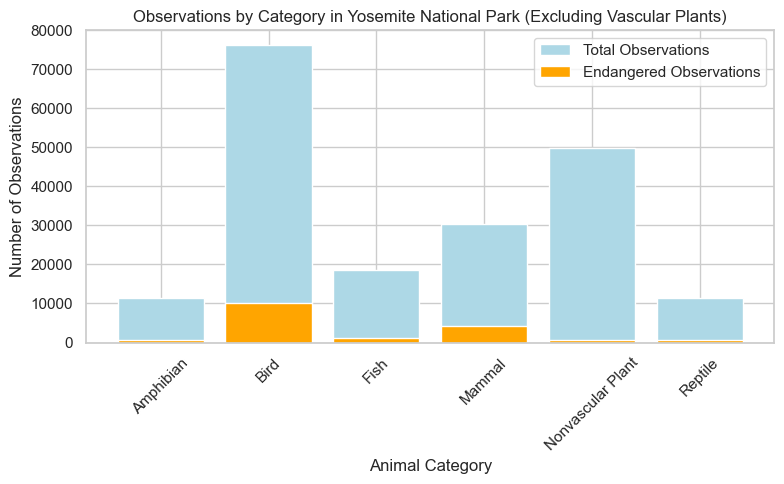

In [ ]:
# Assuming 'agg_df' contains the aggregated data from the previous steps
# Splitting the data into "Vascular Plant" and other categories
vascular_plant_data = agg_df[agg_df['category'] == 'Vascular Plant']
other_categories_data = agg_df[agg_df['category'] != 'Vascular Plant']

# Plot for "Vascular Plant" category by park
plt.figure(figsize=(8, 5))
sns.barplot(
    data=vascular_plant_data,
    x='park_name',
    y='total_observations',
    color='lightblue',
    label='Total Observations'
)
sns.barplot(
    data=vascular_plant_data,
    x='park_name',
    y='endangered_observations',
    color='orange',
    label='Endangered Observations'
)
plt.title('Observations of Vascular Plants by Park')
plt.xlabel('Park Name')
plt.ylabel('Number of Observations')
plt.xticks(rotation=15)  # Rotate labels for clarity
plt.legend()
plt.tight_layout()
plt.show()

# Plot for each park (other categories)
parks = other_categories_data['park_name'].unique()

for park in parks:
    park_data = other_categories_data[other_categories_data['park_name'] == park]
    
    plt.figure(figsize=(8, 5))
    plt.bar(
        park_data['category'],
        park_data['total_observations'],
        label='Total Observations',
        color='lightblue'
    )
    plt.bar(
        park_data['category'],
        park_data['endangered_observations'],
        label='Endangered Observations',
        color='orange'
    )
    plt.title(f'Observations by Category in {park} (Excluding Vascular Plants)')
    plt.xlabel('Animal Category')
    plt.ylabel('Number of Observations')
    plt.xticks(rotation=45)  # Rotate labels for clarity
    plt.legend()
    plt.tight_layout()
    plt.show()


### Observations

* The graphs for the four parks look very similar, even suspiciously so. The absolute number of observation are different, but the distributions look very similar.
* This can be the result of a bug in the code, but it can also indicate the the data is repeated and duplicated. 
* I will check the last hypothesis.

## Investigating the similarity the categories Graphs per park

### Checking whether the data is duplicated

* As mentioned, the graphs for the four parks seem suspiciously similar.
* The suspicion to be checked is that the data has been duplicated from park to park and only multiplied by a different contant for every park 😮

In [ ]:
# Pivot the DataFrame to make parks columns and categories rows
pivoted_data = observations.pivot_table(
    index='scientific_name',
    columns='park_name',
    values='observations',
    aggfunc='sum'
).fillna(0)

# Normalize the data by park (column-wise normalization)
normalized_data = pivoted_data.div(pivoted_data.sum(axis=0), axis=1)
print("Observations dataset - Normalized by Park:")
display(normalized_data)

# Check correlations between parks
correlations = normalized_data.corr()
print("\nObservations dataset - Correlation Coefficients Between Parks:")
display(correlations)

# Check multiplicative ratios between parks
ratios = pivoted_data.div(pivoted_data.iloc[:, 0], axis=0)  # Divide by observations in the first park
print("\nObservations dataset - Multiplicative Ratios (using the first park as a reference):")
display(ratios)


Observations dataset - Normalized by Park:


park_name,Bryce National Park,Great Smoky Mountains National Park,Yellowstone National Park,Yosemite National Park
scientific_name,,,,
Abies bifolia,0.000189,0.000167,0.000149,0.000158
Abies concolor,0.000144,0.000234,0.000167,0.000237
Abies fraseri,0.000189,0.000188,0.000151,0.000127
Abietinella abietina,0.000175,0.000151,0.000168,0.000212
Abronia ammophila,0.000160,0.000167,0.000154,0.000159
...,...,...,...,...
Zonotrichia leucophrys gambelii,0.000101,0.000201,0.000170,0.000196
Zonotrichia leucophrys oriantha,0.000127,0.000285,0.000157,0.000156
Zonotrichia querula,0.000182,0.000192,0.000186,0.000185



Observations dataset - Correlation Coefficients Between Parks:


park_name,Bryce National Park,Great Smoky Mountains National Park,Yellowstone National Park,Yosemite National Park
park_name,,,,
Bryce National Park,1.000000,0.469697,0.694825,0.635368
Great Smoky Mountains National Park,0.469697,1.000000,0.603648,0.550632
Yellowstone National Park,0.694825,0.603648,1.000000,0.804932
Yosemite National Park,0.635368,0.550632,0.804932,1.000000



Observations dataset - Multiplicative Ratios (using the first park as a reference):


park_name,Bryce National Park,Great Smoky Mountains National Park,Yellowstone National Park,Yosemite National Park
scientific_name,,,,
Abies bifolia,1.0,0.660550,1.972477,1.247706
Abies concolor,1.0,1.216867,2.903614,2.469880
Abies fraseri,1.0,0.743119,2.000000,1.009174
Abietinella abietina,1.0,0.643564,2.405941,1.811881
Abronia ammophila,1.0,0.782609,2.413043,1.489130
...,...,...,...,...
Zonotrichia leucophrys gambelii,1.0,1.500000,4.241379,2.913793
Zonotrichia leucophrys oriantha,1.0,1.684932,3.109589,1.849315
Zonotrichia querula,1.0,0.790476,2.552381,1.523810


### Observations

* The results do not show the strong correlation between parks in the *observations* dataset
* So the suspicion that the Observations dataset has been artificially duplicated from park to park, has not been substantiated.
* Let's check now the combined dataset for correlations

### Checking correlations between parks in the combined dataset

Correlations Between Parks (Normalized Total Observations):


park_name,Bryce National Park,Great Smoky Mountains National Park,Yellowstone National Park,Yosemite National Park
park_name,,,,
Bryce National Park,1.000000,0.999994,0.999997,0.999997
Great Smoky Mountains National Park,0.999994,1.000000,0.999999,0.999999
Yellowstone National Park,0.999997,0.999999,1.000000,1.000000
Yosemite National Park,0.999997,0.999999,1.000000,1.000000


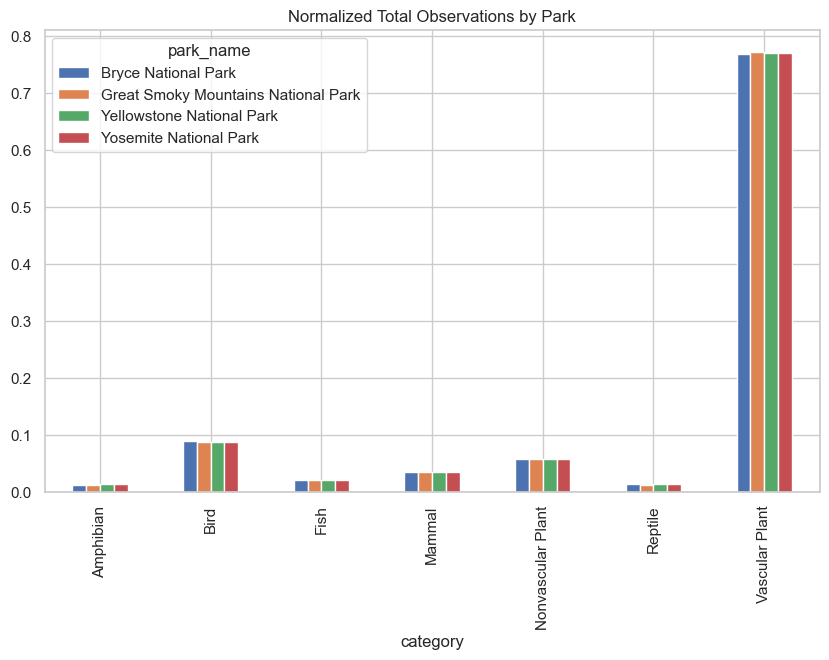


Correlations Between Parks (Normalized Endangered Observations):


park_name,Bryce National Park,Great Smoky Mountains National Park,Yellowstone National Park,Yosemite National Park
park_name,,,,
Bryce National Park,1.000000,0.999225,0.999540,0.999555
Great Smoky Mountains National Park,0.999225,1.000000,0.998768,0.999407
Yellowstone National Park,0.999540,0.998768,1.000000,0.999748
Yosemite National Park,0.999555,0.999407,0.999748,1.000000


In [ ]:
# Normalize observations within each park
agg_df['normalized_total'] = agg_df['total_observations'] / agg_df.groupby('park_name')['total_observations'].transform('sum')
agg_df['normalized_endangered'] = agg_df['endangered_observations'] / agg_df.groupby('park_name')['endangered_observations'].transform('sum')

# Pivot normalized data for correlation analysis
normalized_total_pivot = agg_df.pivot(index='category', columns='park_name', values='normalized_total')
normalized_endangered_pivot = agg_df.pivot(index='category', columns='park_name', values='normalized_endangered')

# Check correlations between parks for normalized total observations
total_correlations = normalized_total_pivot.corr()
print("Correlations Between Parks (Normalized Total Observations):")
display(total_correlations)

normalized_total_pivot.plot(kind='bar', figsize=(10, 6), title='Normalized Total Observations by Park')
plt.show()

# Check correlations between parks for normalized endangered observations
endangered_correlations = normalized_endangered_pivot.corr()
print("\nCorrelations Between Parks (Normalized Endangered Observations):")
display(endangered_correlations)

### Observations

* Perfect correlation between parks, in the combined parks/catgories dataset!
* Although we did not find such a correlation between parks in the observations dataset before the combinination.
* Let's do several more checks.

### Compare Raw Data Across Parks

In the combined dataset without normalization

In [ ]:
raw_pivot = agg_df.pivot(index='category', columns='park_name', values='total_observations')
print("Raw Observations by Park:")
# print(raw_pivot)
display(raw_pivot)
# Check correlations between parks for normalized total observations
raw_correlations = raw_pivot.corr()
print("Correlations Between Parks (Not Normalized Total Observations):")
display(raw_correlations)


Raw Observations by Park:


park_name,Bryce National Park,Great Smoky Mountains National Park,Yellowstone National Park,Yosemite National Park
category,,,,
Amphibian,7380,5707,19440,11444
Bird,51647,37728,127251,76207
Fish,12423,9206,30574,18615
Mammal,20550,15012,50795,30339
Nonvascular Plant,32992,24857,83021,49783
Reptile,7950,5691,19554,11483
Vascular Plant,443083,333619,1112927,665461


Correlations Between Parks (Not Normalized Total Observations):


park_name,Bryce National Park,Great Smoky Mountains National Park,Yellowstone National Park,Yosemite National Park
park_name,,,,
Bryce National Park,1.000000,0.999994,0.999997,0.999997
Great Smoky Mountains National Park,0.999994,1.000000,0.999999,0.999999
Yellowstone National Park,0.999997,0.999999,1.000000,1.000000
Yosemite National Park,0.999997,0.999999,1.000000,1.000000


### Observations

* Still perfect correlation between parks.  
So the normalization didn't cause the correlation.

### Investigating Maximal Cases

* We saw that the parks have turned out to be perfectly correlated in terms of observations by category. But the parks were not strongly correlated with regard to observations by species. So we will try to find some differences between the parks in another path.
* Because of the perfect correlation by category, we can go ahead and normalize the number of observations, so that there will be an equal number of (normalized) observations for each park.
* For each park p, we will look at the most observed species mos(p), and compare observations of mos(p) for all the parks. We will repeat this for endangered species. We will ignore plants in this comparison, because they are observed a lot, but less critical for conservation.

In [ ]:
# Step 1: Normalize Observations Across Parks
total_observations_per_park = merged_df.groupby('park_name')['observations'].sum()
scaling_factors = total_observations_per_park.max() / total_observations_per_park
merged_df['normalized_observations'] = merged_df['observations'] * merged_df['park_name'].map(scaling_factors)

# Step 2: Find the Most Observed Non-Plant Species Per Park
non_plants = merged_df[merged_df['category'] != 'Vascular Plant']
most_observed_species = non_plants.loc[non_plants.groupby('park_name')['normalized_observations'].idxmax()].copy()
most_observed_species['park_name'] = non_plants.loc[most_observed_species.index, 'park_name'].values  # Fix park name issue

# Step 3: Detect and Reduce Duplicate Graphs for Non-Plants
species_to_parks = most_observed_species.groupby('scientific_name')['park_name'].apply(lambda x: list(map(str, x))).to_dict()

# Step 4: Generate Graphs for Most Observed Non-Plants
for species_name, parks_list in species_to_parks.items():
    species_data = merged_df[merged_df['scientific_name'] == species_name]
    common_names = species_data['common_names'].iloc[0]  # Use first occurrence

    park_names_str = ', '.join(parks_list)
    plt.figure(figsize=(8, 5))
    plt.bar(species_data['park_name'], species_data['normalized_observations'], color='skyblue')
    plt.title(f"Most Observed Species in Park(s) {park_names_str}:\n{species_name} ({common_names}) - Normalized Observations Across Parks")
    plt.xlabel("Park Name")
    plt.ylabel("Normalized Observations")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Chi-Square Test for This Species
    contingency_table = species_data.pivot(index='scientific_name', columns='park_name', values='normalized_observations').fillna(0)
    display(contingency_table)
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    
    print(f"\nChi-Square Test for {species_name}:")
    print(f"Chi-Square Test Statistic: {chi2}, p-value: {p_value}")

    if p_value < 0.05:
        print("Statistically significant differences exist between parks.")
    else:
        print("No statistically significant difference between parks.")

# Step 5: Find the Most Observed Endangered Species Per Park
endangered_species = non_plants[non_plants['is_endangered']]
most_observed_endangered = endangered_species.loc[endangered_species.groupby('park_name')['normalized_observations'].idxmax()].copy()
most_observed_endangered['park_name'] = endangered_species.loc[most_observed_endangered.index, 'park_name'].values  # Fix park name issue

# Step 6: Detect and Reduce Duplicate Graphs for Endangered Species
endangered_to_parks = most_observed_endangered.groupby('scientific_name')['park_name'].apply(lambda x: list(map(str, x))).to_dict()

# Step 7: Generate Graphs for Most Observed Endangered Species
for species_name, parks_list in endangered_to_parks.items():
    species_data = merged_df[merged_df['scientific_name'] == species_name]
    common_names = species_data['common_names'].iloc[0]  # Use first occurrence

    park_names_str = ', '.join(parks_list)
    plt.figure(figsize=(8, 5))
    plt.bar(species_data['park_name'], species_data['normalized_observations'], color='orange')
    plt.title(f"Most Observed Endangered Species in Park(s) {park_names_str}:\n{species_name} ({common_names}) - Normalized Observations Across Parks")
    plt.xlabel("Park Name")
    plt.ylabel("Normalized Observations")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Chi-Square Test for This Endangered Species
    observed = species_data['normalized_observations'].values
    if len(observed) < 2:
        print(f"Not enough data for Chi-Square Test for {species_name}.")
        continue
    expected = np.mean(observed) * np.ones_like(observed)  # Use mean as expected values
    chi2, p_value, _, _ = chi2_contingency([observed, expected])
    # contingency_table = species_data.pivot(index='scientific_name', columns='park_name', values='normalized_observations').fillna(0)
    # display(contingency_table)
    # chi2, p_value, _, _ = chi2_contingency(contingency_table)
    
    print(f"\nChi-Square Test for {species_name}:")
    print(f"Chi-Square Test Statistic: {chi2}, p-value: {p_value}")

    if p_value < 0.05:
        print("Statistically significant differences exist between parks.")
    else:
        print("No statistically significant difference between parks.")

NameError: name 'merged_df' is not defined

### Observations

* We have seen the comparing total observations by species categories did not reveal differences between the parks, after scaling.
* But now we can se that maximual cases analysis does reveal differences between the parks. Different species are most-observed in different parks. And even when the species are the same, the (normalized) observation counts are different.